In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, precision_recall_curve, auc
import shap

Import Data set locally

In [10]:
# Load dataset
df = pd.read_csv("/content/creditcard.csv")

# Check class distribution
print(df["Class"].value_counts())

Class
0.0    239235
1.0       437
Name: count, dtype: int64


In [ ]:
# Separate features and target
X = df.drop(columns=["Class"])
y = df["Class"]
df['Class'].fillna(df['Class'].mode()[0], inplace=True)

In [11]:
# Standardize 'Amount' and 'Time' (since they are not PCA-transformed)
scaler = StandardScaler()
X[["Amount", "Time"]] = scaler.fit_transform(X[["Amount", "Time"]])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)
# Handle imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Resampled training set: {np.bincount(y_train_resampled)}")  # Balanced dataset


Resampled training set: [41152 41152]


In [12]:
# Train XGBoost classifier
xgb_model = XGBClassifier(
    scale_pos_weight=56864/98,  # Balances the classes
    n_estimators=500,  # More trees can improve recall
    learning_rate=0.05,  # Slower learning for better generalization
    max_depth=6,  # Prevent overfitting
    colsample_bytree=0.8,  # Feature selection
    subsample=0.8,  # Sampled training for generalization
    eval_metric="aucpr",  # Uses Precision-Recall AUC
    use_label_encoder=False,
    random_state=42
)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred = xgb_model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc:.4f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:56:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10289
         1.0       0.74      0.93      0.82        30

    accuracy                           1.00     10319
   macro avg       0.87      0.97      0.91     10319
weighted avg       1.00      1.00      1.00     10319

Precision-Recall AUC: 0.9650


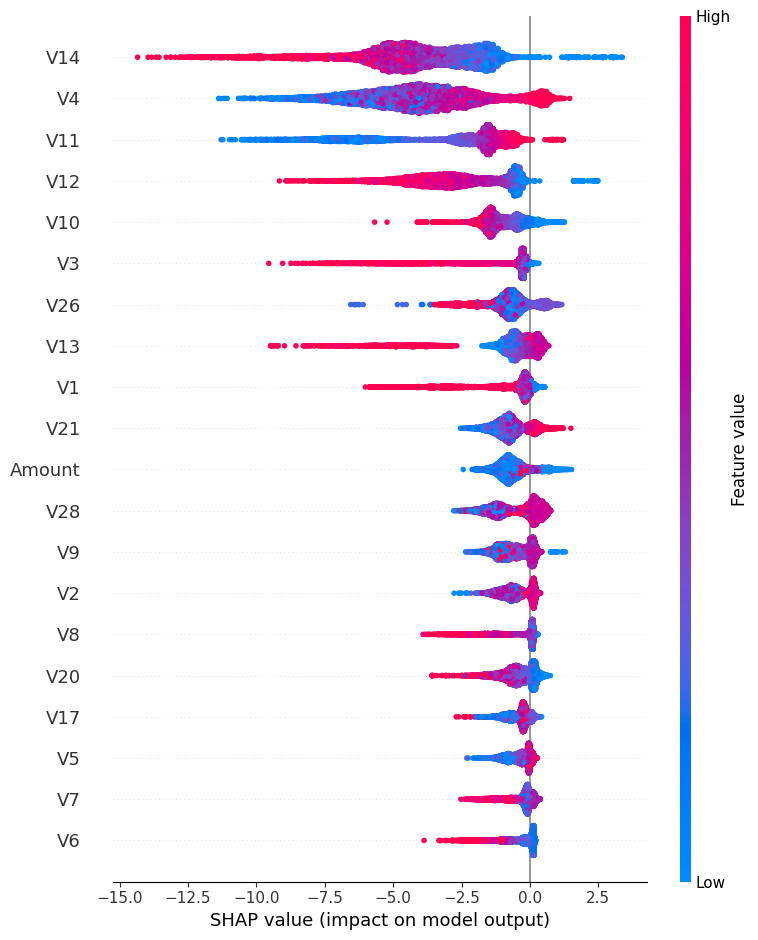

In [ ]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)  # Use TreeExplainer's shap_values method

# Convert X_test to DataFrame if not already
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# SHAP summary plot (Global feature importance)
shap.summary_plot(shap_values, X_test_df)

# SHAP force plot (Local explanation for a single prediction)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test_df.iloc[0])


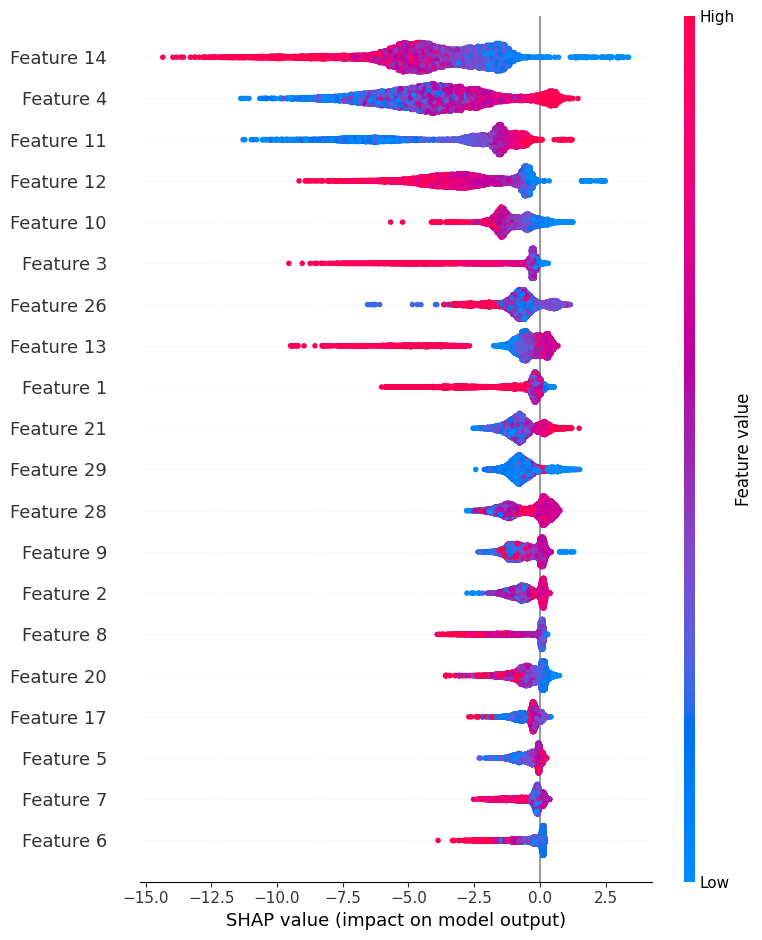

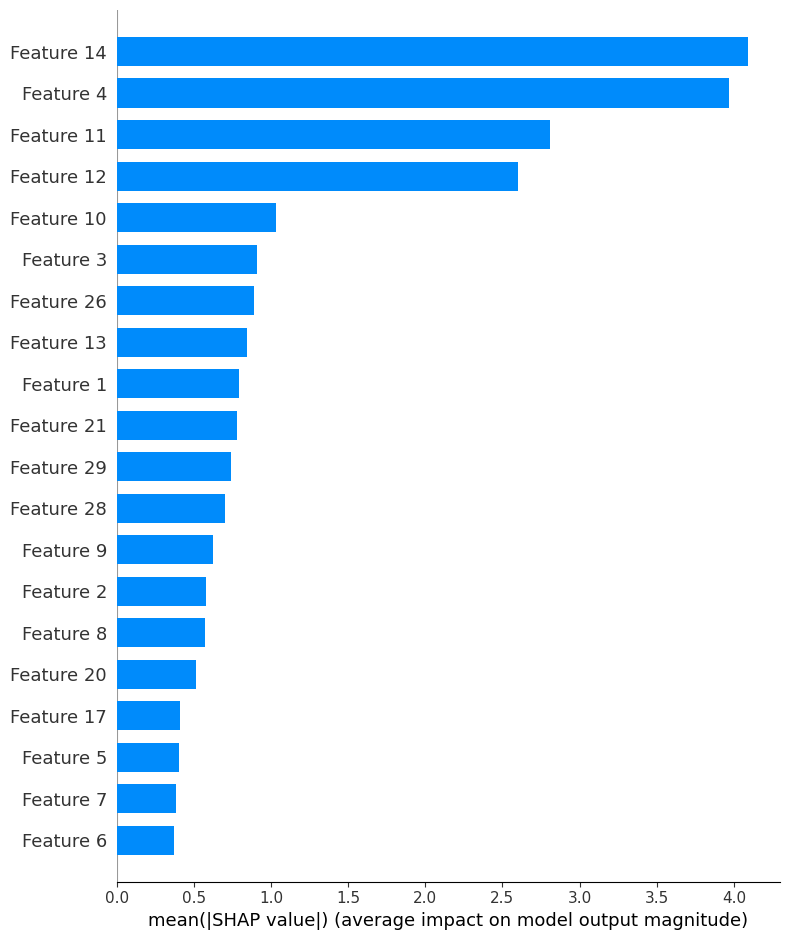

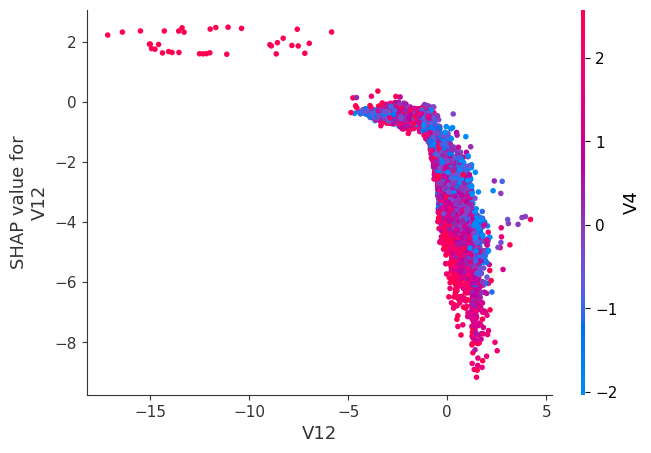

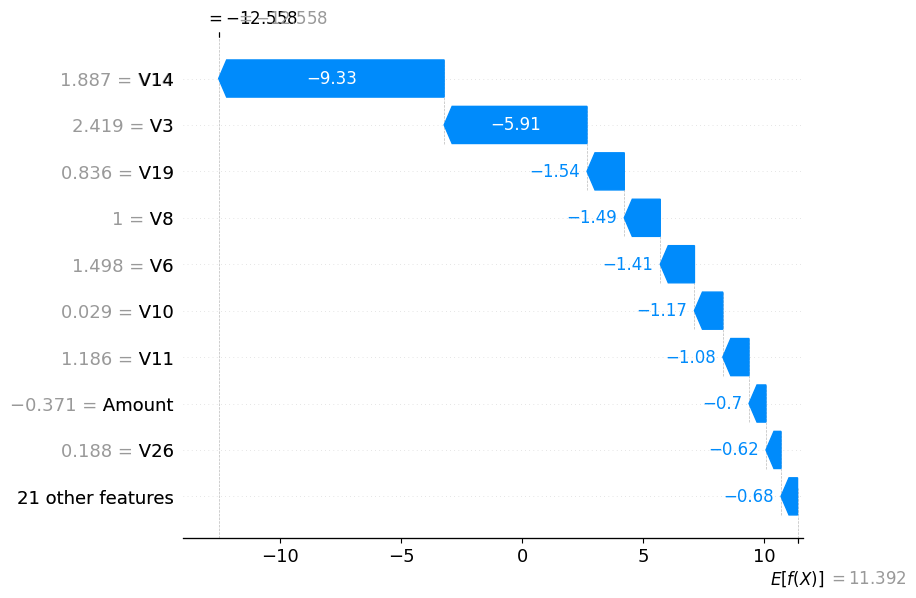

In [13]:
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.dependence_plot(X_test_df.columns.get_loc("V12"), shap_values, X_test_df)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test_df.iloc[0])
#shap.waterfall_plot(shap_values[0])
# Create an Explanation object for a single prediction
shap_explanation = shap.Explanation(
    values=shap_values[0],  # SHAP values for the first instance
    base_values=explainer.expected_value,  # Expected value (base prediction)
    data=X_test_df.iloc[0]  # Feature values for the instance
)

# Generate the waterfall plot
shap.waterfall_plot(shap_explanation)